<a href="https://colab.research.google.com/github/IrynaBarnych/AI14/blob/hw/module4/%D0%94%D0%97_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Імпорт модулів

In [413]:
import pandas as pd
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

Дані про гриби

[посилання](https://www.kaggle.com/datasets/uciml/mushroom-classification)

In [414]:
# трохи обробки даних
from sklearn.preprocessing import OrdinalEncoder

df = pd.read_csv('https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/main/module3/data/mushrooms.csv')
df = df.drop(columns='veil-type')

encoder = OrdinalEncoder().set_output(transform='pandas')
df = encoder.fit_transform(df).astype(int)

columns = df.columns.delete(0)
data = df[columns]
df[columns] = (data - data.min()) / (data.max() - data.min())

Дані непогано збалансовані

In [415]:
df['class'].value_counts()

class
0    4208
1    3916
Name: count, dtype: int64

In [416]:
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,1.0,0.666667,0.444444,1.0,0.750,1.0,0.0,1.0,0.363636,...,0.666667,0.666667,0.875,0.875,0.666667,0.5,1.0,0.250,0.6,0.833333
1,0,1.0,0.666667,1.000000,1.0,0.000,1.0,0.0,0.0,0.363636,...,0.666667,0.666667,0.875,0.875,0.666667,0.5,1.0,0.375,0.4,0.166667
2,0,0.0,0.666667,0.888889,1.0,0.375,1.0,0.0,0.0,0.454545,...,0.666667,0.666667,0.875,0.875,0.666667,0.5,1.0,0.375,0.4,0.500000
3,1,1.0,1.000000,0.888889,1.0,0.750,1.0,0.0,1.0,0.454545,...,0.666667,0.666667,0.875,0.875,0.666667,0.5,1.0,0.250,0.6,0.833333
4,0,1.0,0.666667,0.333333,0.0,0.625,1.0,1.0,0.0,0.363636,...,0.666667,0.666667,0.875,0.875,0.666667,0.5,0.0,0.375,0.0,0.166667


Потрібно на основі інформації про гриб зрозуміти чи він їстівним(клас 1) `class`

# Завдання 1
Створіть клас Dataset для тренувальних та тестових даних

In [417]:
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

class MyDataset(Dataset):
    def __init__(self, X, y):
      self.X = torch.FloatTensor(X.values)
      self.y = torch.FloatTensor(y.values)
      self.y = self.y.reshape(-1, 1)

    def __len__(self):
      return len(self.X)

    def __getitem__(self, idx):
      return self.X[idx], self.y[idx]

# Create dataset object
X = df.drop(columns=['class'])
y = df['class']

dataset = MyDataset(X, y)

In [418]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=42,
                                                    stratify=y)

dataset_train = MyDataset(X_train, y_train)
dataset_test = MyDataset(X_test, y_test)


# Завдання 2
Створіть DataLoader

In [419]:
from torch.utils.data import DataLoader

batch_size = 112
train_dl = DataLoader(dataset_train,
                      batch_size=batch_size,
                      shuffle=True)

test_dl = DataLoader(dataset_test,
                     batch_size=batch_size,
                     shuffle=True)

# Завдання 3
Створіть нейромережу

In [420]:
import numpy as np
from torch import nn
import torch.nn.functional as F


class Block(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.linear = nn.Linear(input_dim, output_dim)

        self.linear1 = nn.Linear(output_dim, output_dim)
        self.bn1 = nn.BatchNorm1d(output_dim)
        self.linear2 = nn.Linear(output_dim, output_dim)
        self.bn2 = nn.BatchNorm1d(output_dim)


    def forward(self, x):
        x = self.linear(x)
        x = F.relu(x)   # output_dim

        out = self.linear1(x) # output_dim
        out = self.bn1(out)
        out = F.relu(out)

        out = self.linear2(out)
        out = self.bn2(out)
        out = F.relu(out) # output_dim

        return out + x  # output_dim

In [421]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        self.block1 = Block(input_dim, hidden_dim)
        self.block2 = Block(hidden_dim, hidden_dim)
        self.block3 = Block(hidden_dim, hidden_dim)
        self.block4 = Block(hidden_dim, hidden_dim)
        self.block5 = Block(hidden_dim, hidden_dim)
        self.block6 = Block(hidden_dim, hidden_dim//2)

        self.linear1 = nn.Linear(hidden_dim//2, hidden_dim//2)
        self.linear2 = nn.Linear(hidden_dim//2, output_dim)

    def forward(self, x):
        out = self.block1(x)
        out = F.dropout(out, 0.2)

        out = self.block2(out)
        out = F.dropout(out, 0.2)

        out = self.block3(out)
        out = F.dropout(out, 0.2)

        out = self.block4(out)
        out = F.dropout(out, 0.2)

        out = self.block5(out)
        out = F.dropout(out, 0.2)

        out = self.block6(out)
        out = F.dropout(out, 0.2)

        out = self.linear1(out)
        out = F.relu(out)

        out = self.linear2(out)
        out = F.sigmoid(out)

        return out


    def predict(self, X, device='cpu'):
        X = torch.FloatTensor(np.array(X)).to(device)

        with torch.no_grad():
          y_pred = self.forward(X)

        return y_pred.cpu().numpy()


model = BinaryClassifier(21, 128, 1).to(device)
model

BinaryClassifier(
  (block1): Block(
    (linear): Linear(in_features=21, out_features=128, bias=True)
    (linear1): Linear(in_features=128, out_features=128, bias=True)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear2): Linear(in_features=128, out_features=128, bias=True)
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block2): Block(
    (linear): Linear(in_features=128, out_features=128, bias=True)
    (linear1): Linear(in_features=128, out_features=128, bias=True)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear2): Linear(in_features=128, out_features=128, bias=True)
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block3): Block(
    (linear): Linear(in_features=128, out_features=128, bias=True)
    (linear1): Linear(in_features=128, out_features=128, bias=True)
    (bn1)

In [422]:
from torchsummary import summary

summary(model, input_size=(21,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           2,816
            Linear-2                  [-1, 128]          16,512
       BatchNorm1d-3                  [-1, 128]             256
            Linear-4                  [-1, 128]          16,512
       BatchNorm1d-5                  [-1, 128]             256
             Block-6                  [-1, 128]               0
            Linear-7                  [-1, 128]          16,512
            Linear-8                  [-1, 128]          16,512
       BatchNorm1d-9                  [-1, 128]             256
           Linear-10                  [-1, 128]          16,512
      BatchNorm1d-11                  [-1, 128]             256
            Block-12                  [-1, 128]               0
           Linear-13                  [-1, 128]          16,512
           Linear-14                  [

# Завдання 4
Визначте функцію втрат та оптимізатор, можливо графік швидкості навчання

In [423]:
class WeightedBCE(nn.Module):
    def __init__(self, pos_weight, neg_weight=1):
        super(WeightedBCE, self).__init__()
        self.neg_weight = neg_weight
        self.pos_weight = pos_weight

    def forward(self, input, target):
        assert input.shape == target.shape, "The loss function received invalid input shapes"
        y_hat = input
        loss = -1.0 * (self.pos_weight * target * torch.log(y_hat + 1e-6) + self.neg_weight * (1 - target) * torch.log(1 - y_hat + 1e-6))
        # Account for 0 times inf which leads to nan
        loss[torch.isnan(loss)] = 0
        # We average across each of the extra attribute dimensions to generalize it
        loss = loss.mean(dim=1)
        # We use mean reduction for our task
        return loss.mean()

# Завдання 5
Натренуйте нейромережу.

In [424]:
loss_fn = WeightedBCE(1)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)

In [425]:
from torch.optim.lr_scheduler import StepLR

scheduler = StepLR(optimizer, step_size=20, gamma=0.1)

# Завдання 6
Збережіть нейромережу та зробіть прогноз

In [426]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    '''
    Runs training loop for classification problems. Returns Keras-style
    per-epoch history of loss and accuracy over training and validation data.

    Parameters
    ----------
    model : nn.Module
        Neural network model
    optimizer : torch.optim.Optimizer
        Search space optimizer (e.g. Adam)
    loss_fn :
        Loss function (e.g. nn.CrossEntropyLoss())
    train_dl :
        Iterable dataloader for training data.
    val_dl :
        Iterable dataloader for validation data.
    metrics: list
        List of sklearn metrics functions to be calculated
    metrics_name: list
        List of matrics names
    epochs : int
        Number of epochs to run
    device : string
        Specifies 'cuda' or 'cpu'
    task : string
        type of problem. It can be regression, binary or multiclass

    Returns
    -------
    Dictionary
        Similar to Keras' fit(), the output dictionary contains per-epoch
        history of training loss, training accuracy, validation loss, and
        validation accuracy.
    '''

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['lr'] = []
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
              try:
                  history_train[name] += func(y, y_pred) * x.size(0)
              except:
                  if task == 'binary': y_pred_ = y_pred.round()
                  elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                  history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)

        scheduler.step()
        history['lr'].append(scheduler.get_last_lr())


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history


In [427]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_fn, train_dl, test_dl,
                epochs=20,
                metrics=[accuracy_score],
                device=device,
                task='binary')

train() called: model=BinaryClassifier, opt=Adam(lr=0.010000), epochs=20, device=cpu

Epoch    1    2sec	loss:      0.157	val_loss:      0.956	accuracy_score:      0.933	val_accuracy_score:      0.843	
Epoch    2    1sec	loss:     0.0316	val_loss:      0.228	accuracy_score:       0.99	val_accuracy_score:       0.94	
Epoch    3    1sec	loss:     0.0591	val_loss:     0.0654	accuracy_score:      0.983	val_accuracy_score:      0.991	
Epoch    4    2sec	loss:      0.016	val_loss:     0.0184	accuracy_score:      0.996	val_accuracy_score:       0.99	
Epoch    5    2sec	loss:     0.0341	val_loss:     0.0462	accuracy_score:      0.993	val_accuracy_score:      0.986	
Epoch    6    1sec	loss:     0.0221	val_loss:     0.0475	accuracy_score:      0.995	val_accuracy_score:      0.988	
Epoch    7    2sec	loss:     0.0101	val_loss:      0.125	accuracy_score:      0.998	val_accuracy_score:      0.966	
Epoch    8    2sec	loss:      0.223	val_loss:      0.546	accuracy_score:      0.954	val_accuracy_score

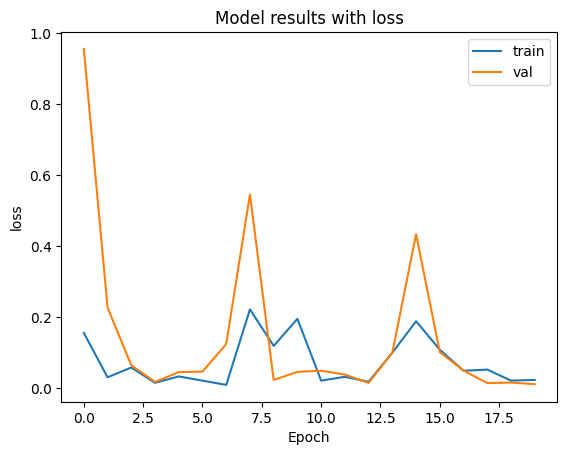

In [428]:

import matplotlib.pyplot as plt

def plot_metric(history, name):
  plt.title(f"Model results with {name}")
  plt.plot(history[name], label='train')
  plt.plot(history['val_'+name], label='val')
  plt.xlabel('Epoch')
  plt.ylabel(name)
  plt.legend()


plot_metric(history, 'loss')

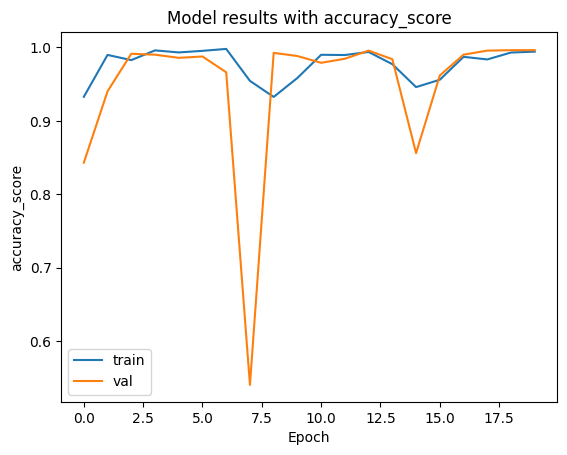

In [429]:
plot_metric(history, 'accuracy_score')

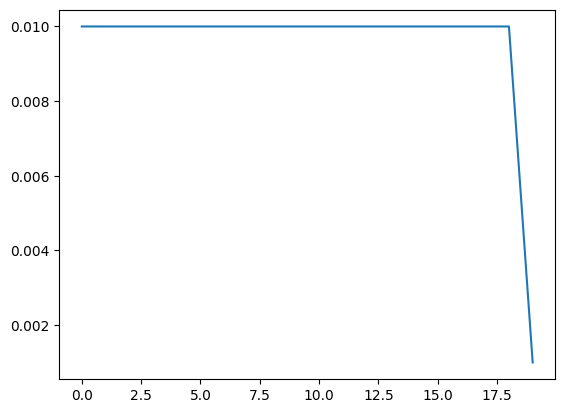

In [430]:
plt.plot(history['lr'])


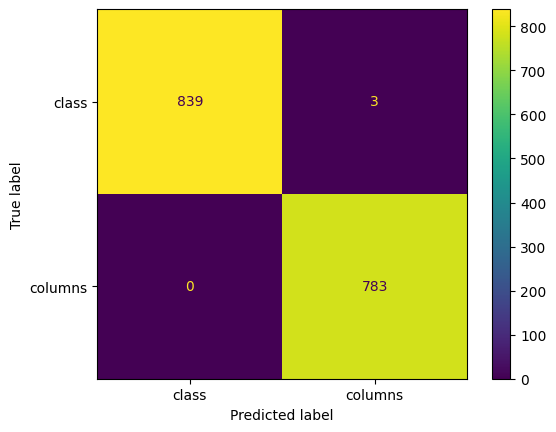

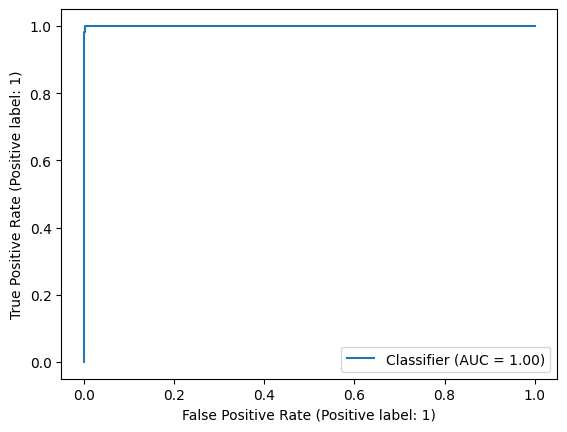

In [431]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

model = model.to('cpu')
y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred.round(),
                                        display_labels=['class', 'columns'])
plt.plot()

RocCurveDisplay.from_predictions(y_test, y_pred, pos_label=1)